## Importing libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import geopandas
import plotly.express as px
import numpy
import seaborn as sns

['Albania' 'Austria' 'Bosnia and Herzegovina' 'Belgium' 'Bulgaria'
 'Switzerland' 'Cyprus' 'Czechia' 'Germany' 'Denmark' 'Estonia' 'Greece'
 'Spain' 'Finland' 'France' 'Croatia' 'Hungary' 'Ireland' 'Iceland'
 'Italy' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Latvia' 'Montenegro'
 'North Macedonia' 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal'
 'Romania' 'Serbia' 'Sweden' 'Slovenia' 'Slovakia' 'Türkiye'
 'England and Wales' 'Scotland (NUTS 2021)'
 'Northern Ireland (UK) (NUTS 2021)' 'Kosovo*']


C:\Users\adami\AppData\Local\Temp\ipykernel_29928\961906294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)


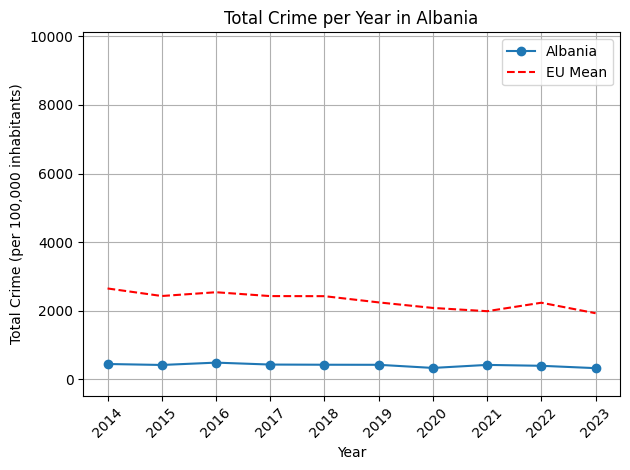

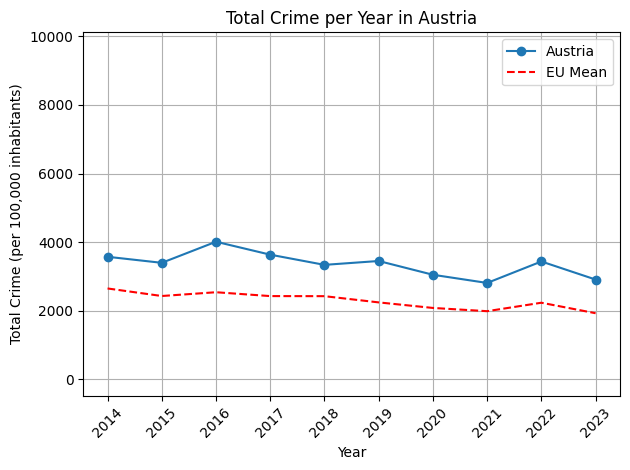

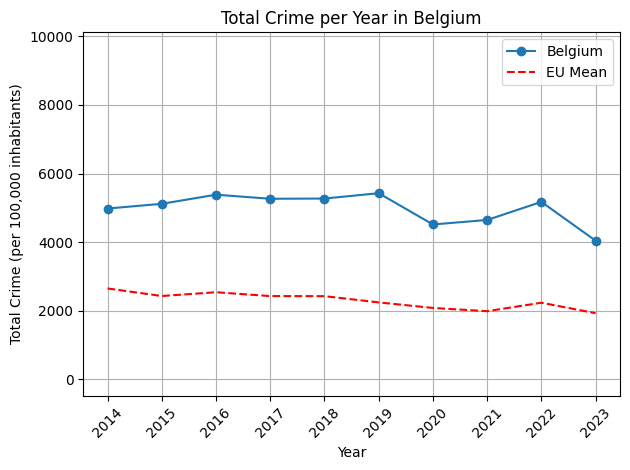

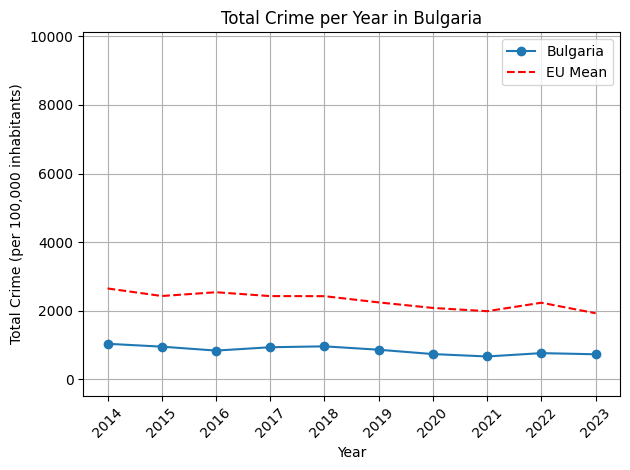

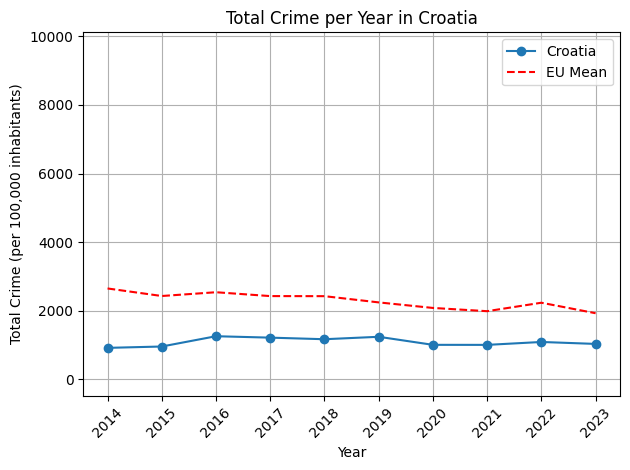

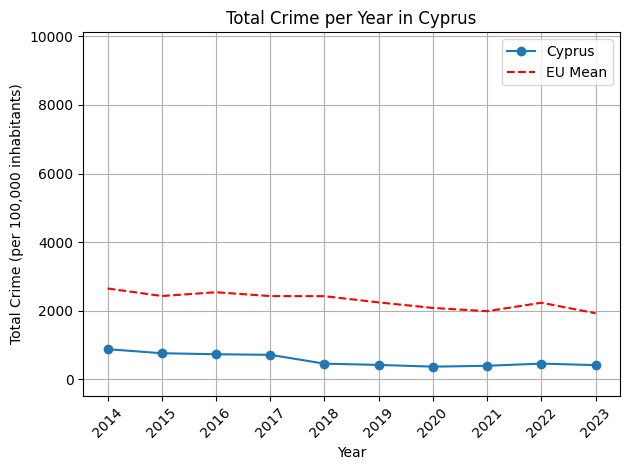

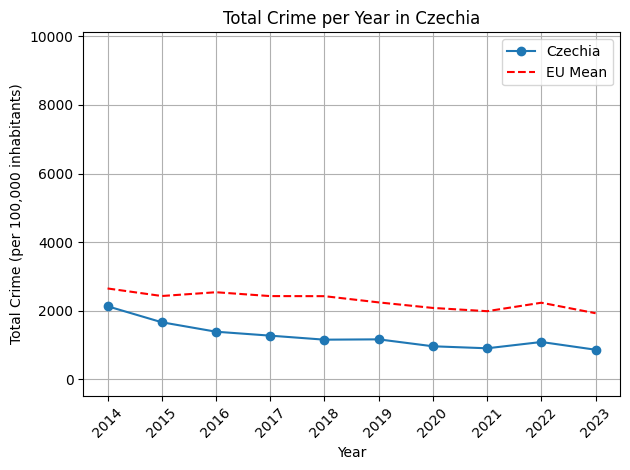

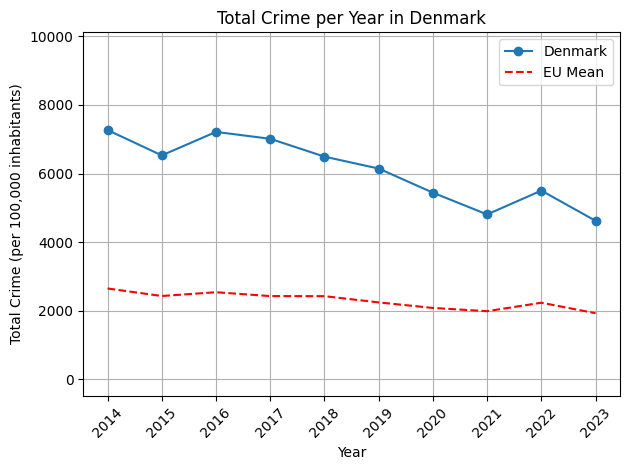

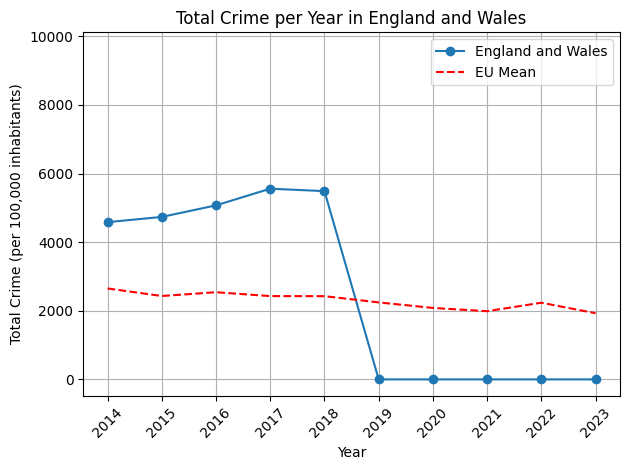

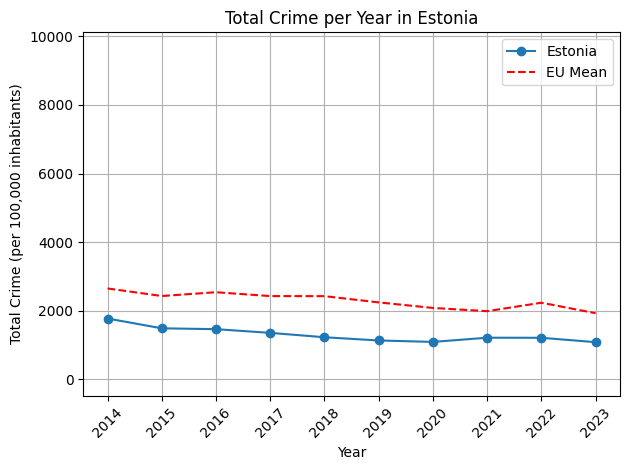

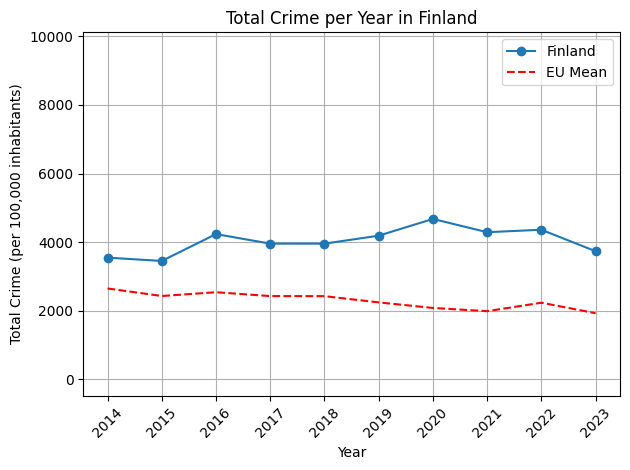

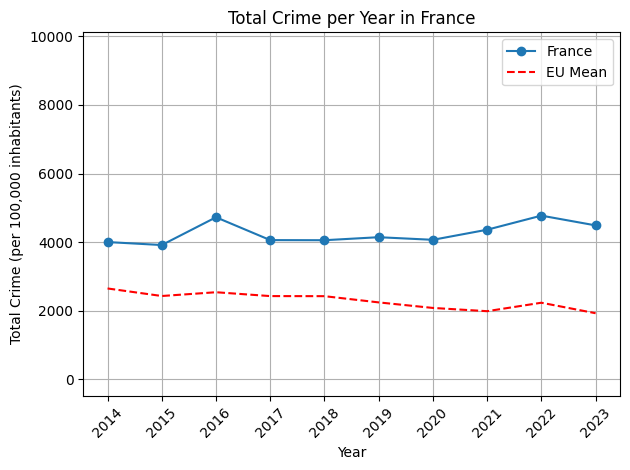

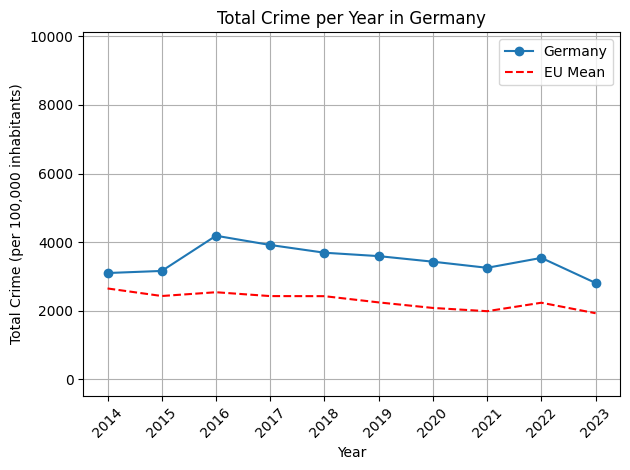

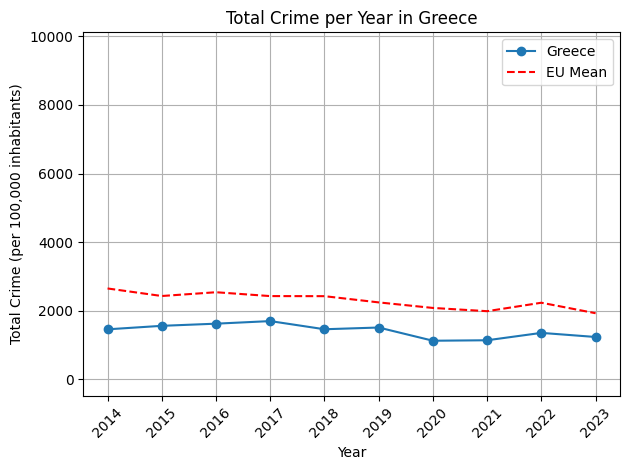

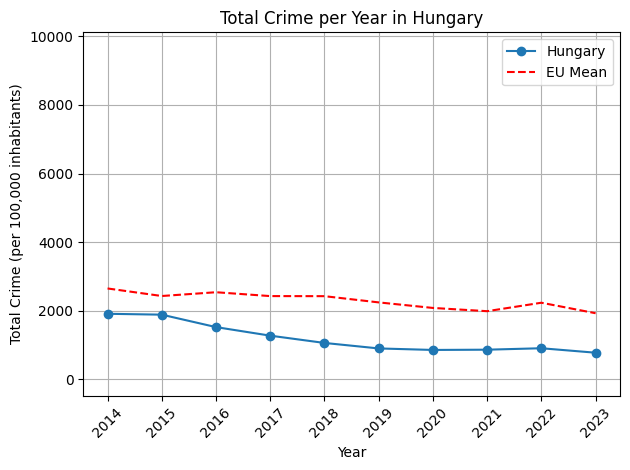

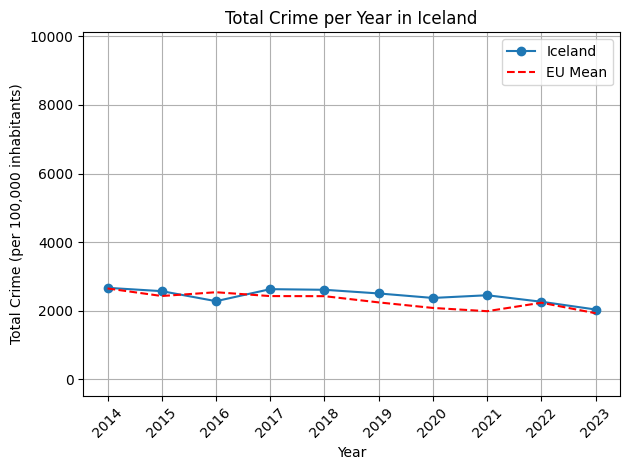

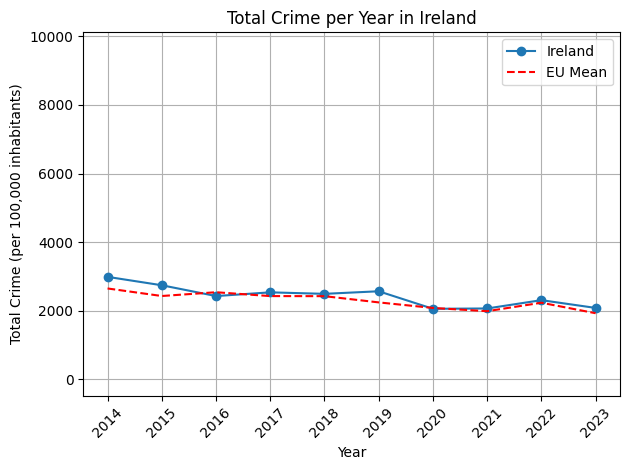

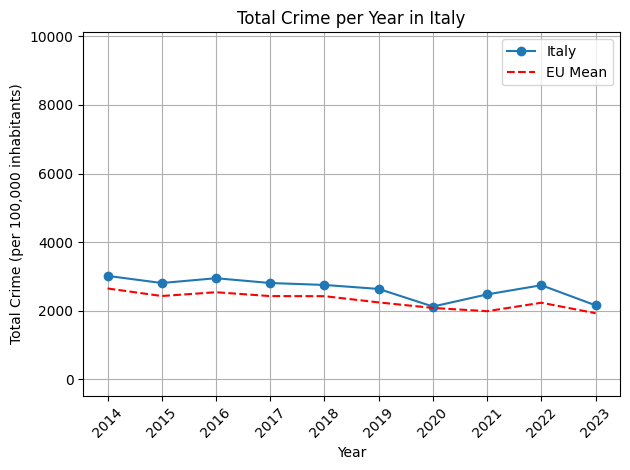

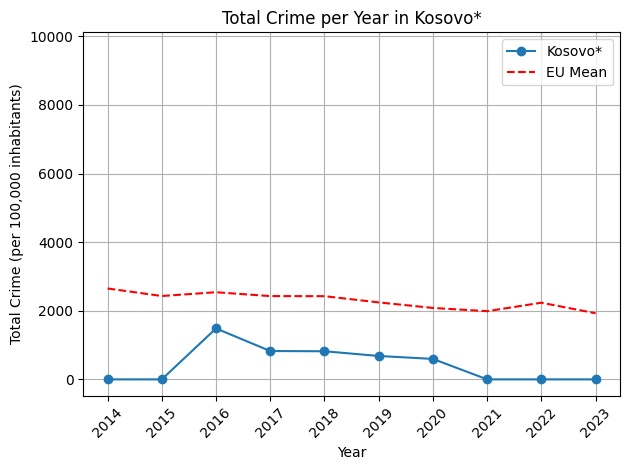

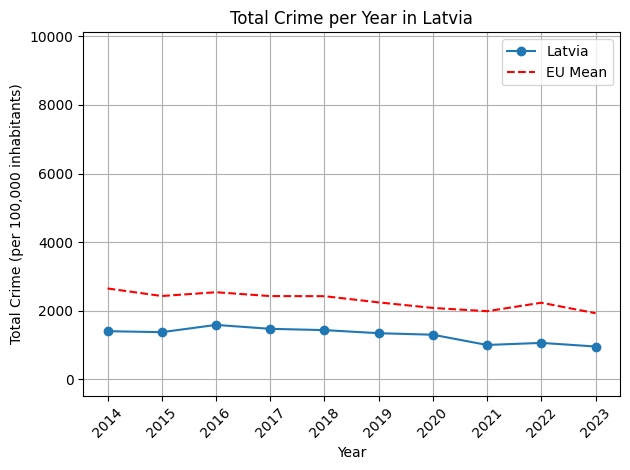

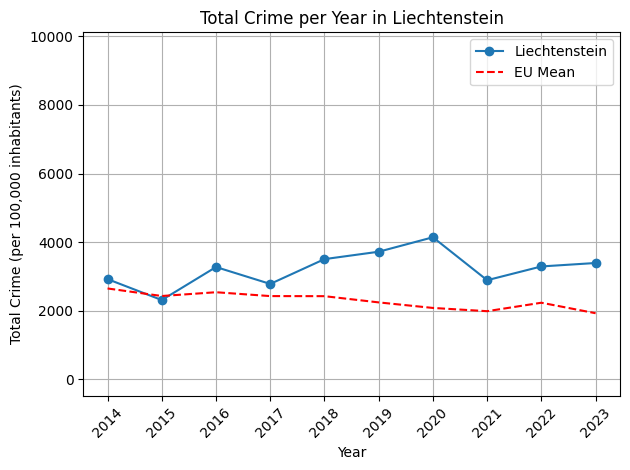

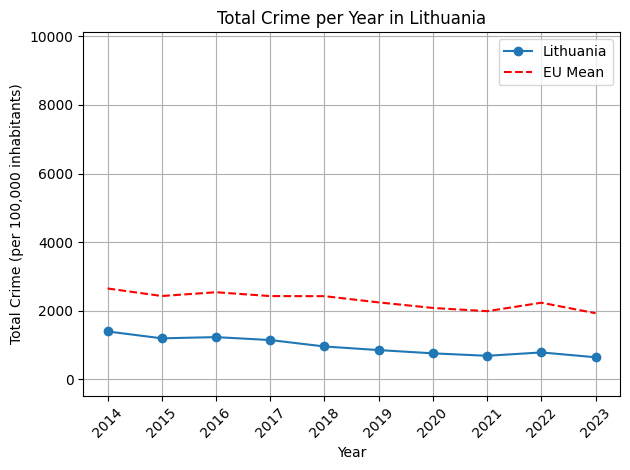

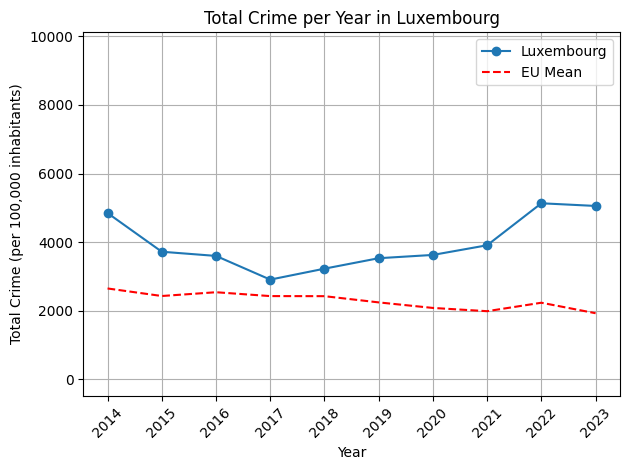

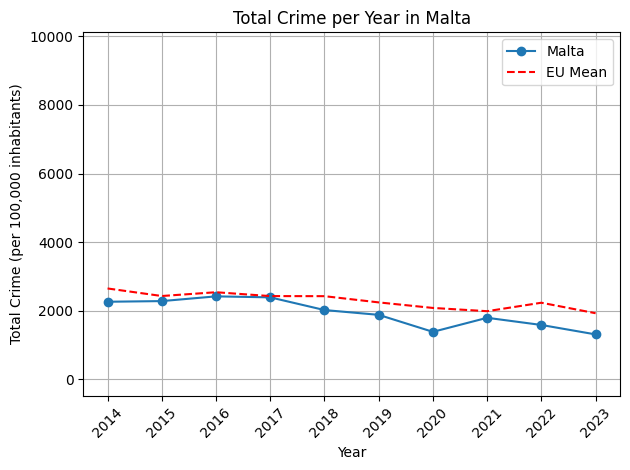

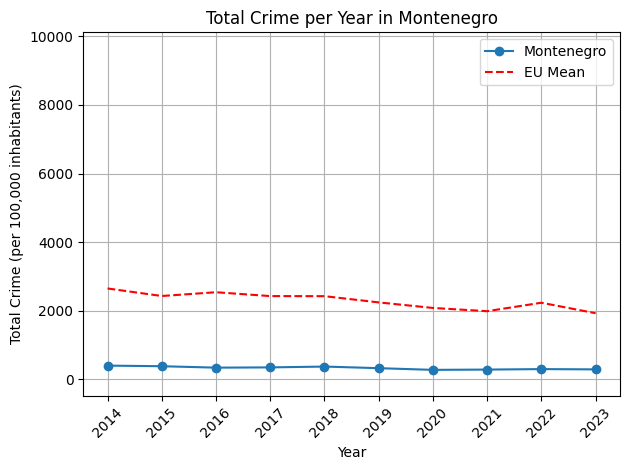

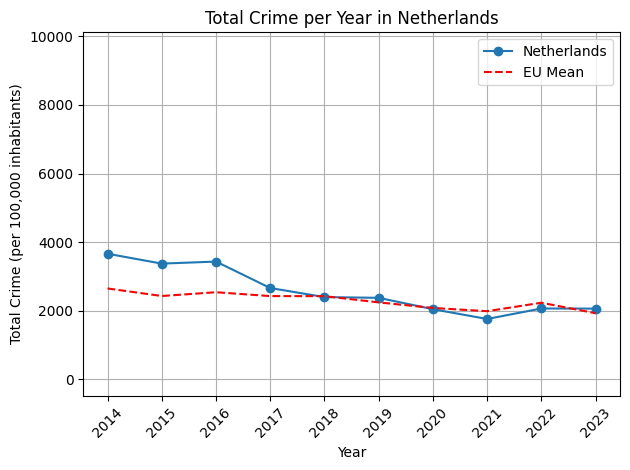

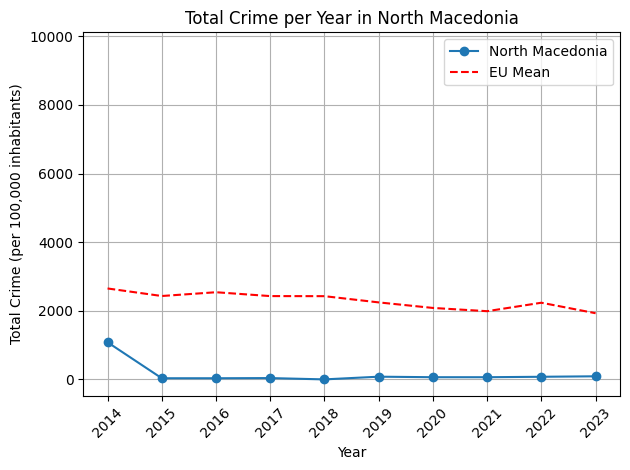

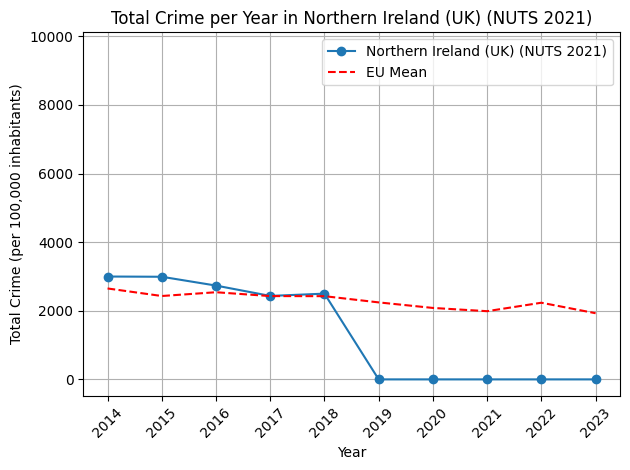

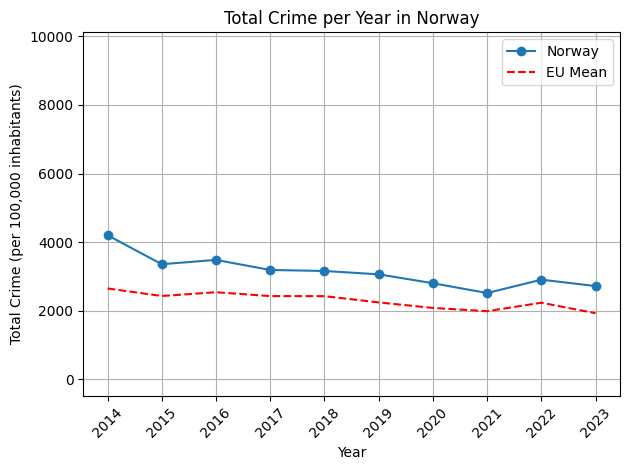

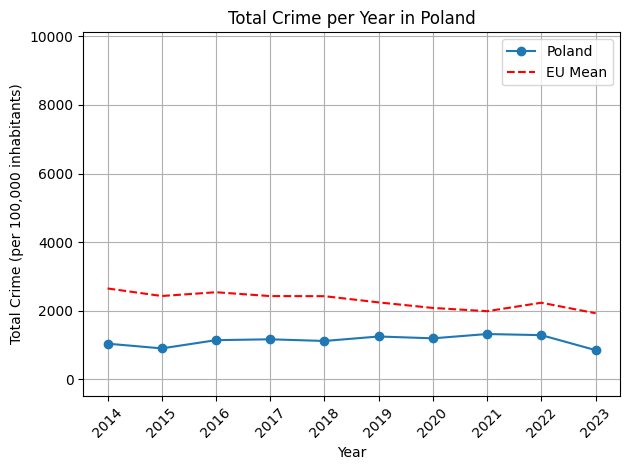

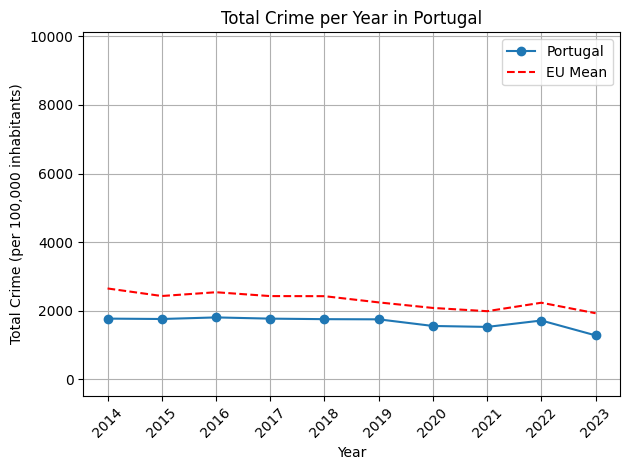

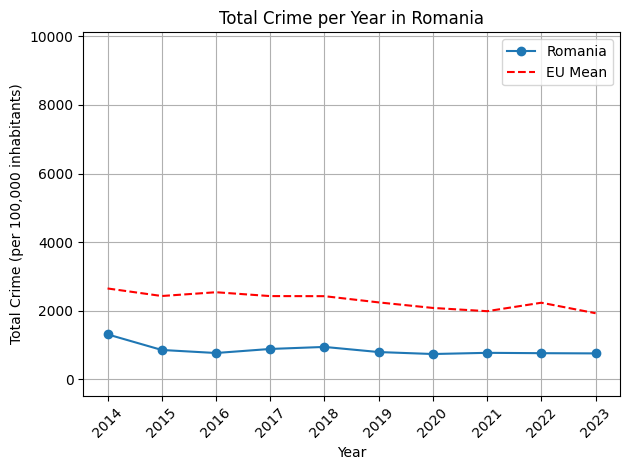

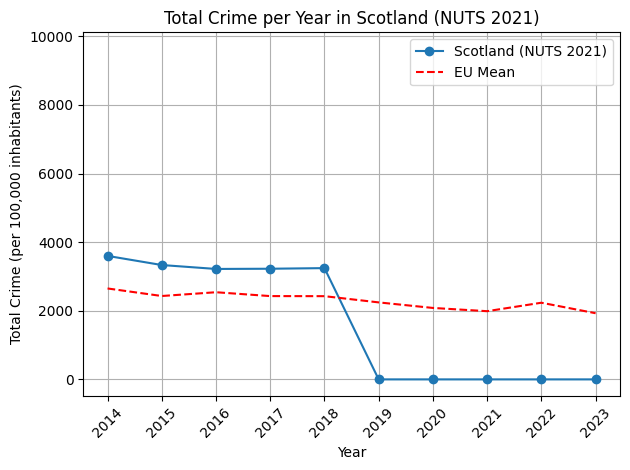

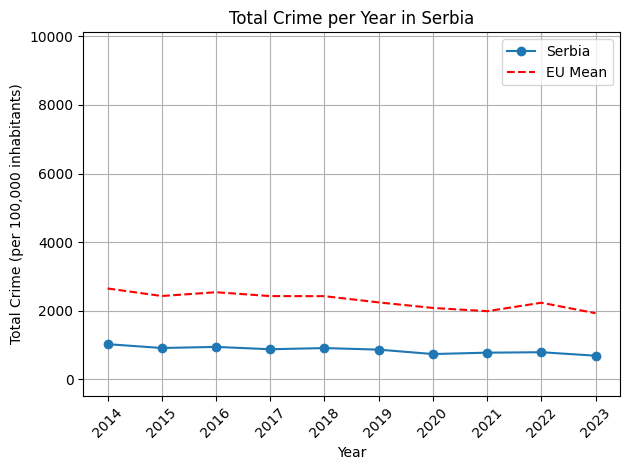

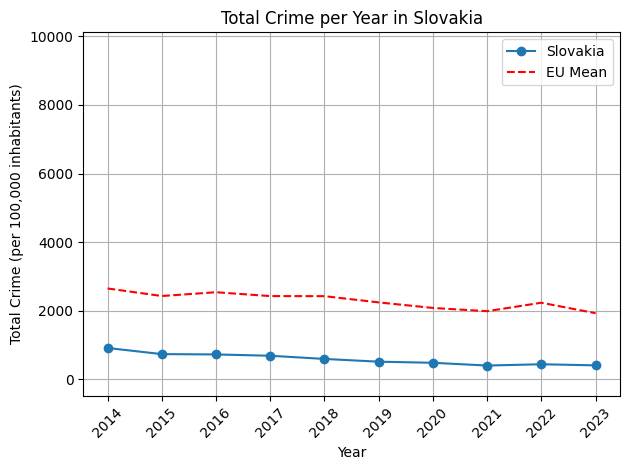

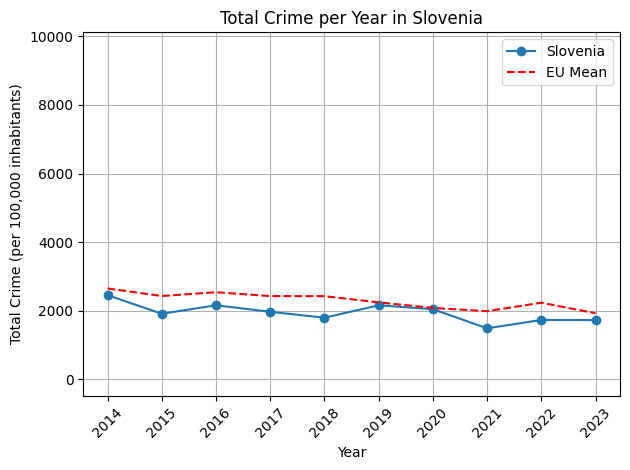

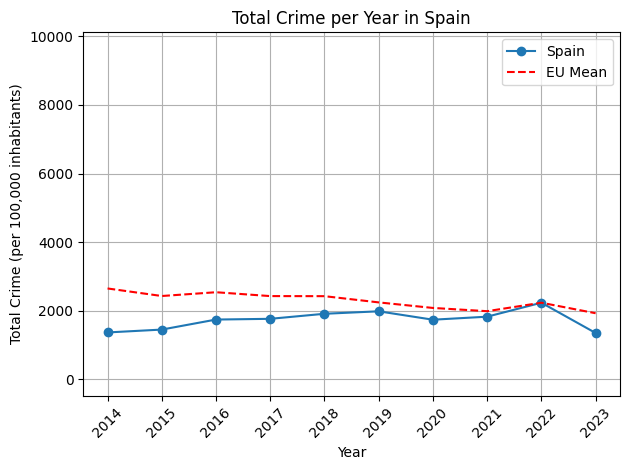

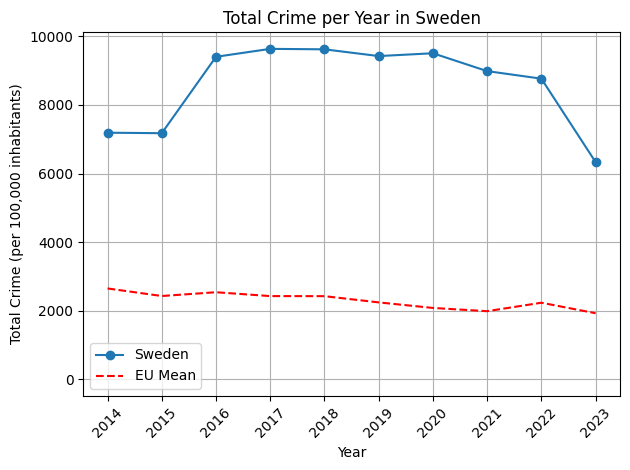

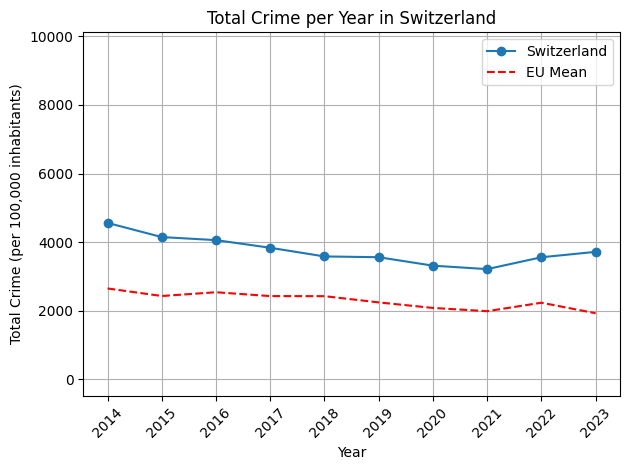

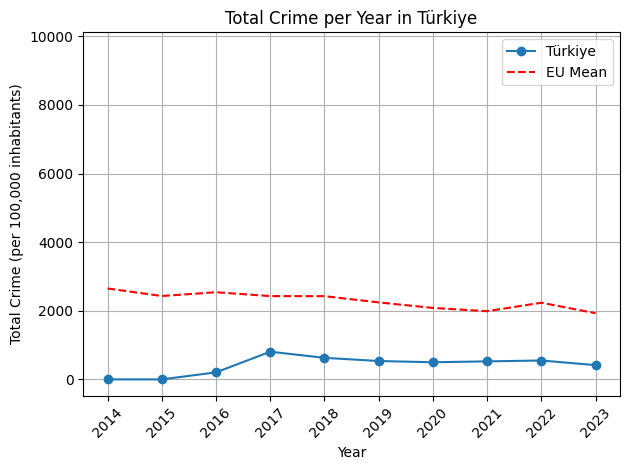

In [6]:
crime_table = pd.read_csv("../Data/crime/crime_statistics.csv")

# Filter relevant rows
filtered = crime_table[crime_table["Unit of measure"] == "Per hundred thousand inhabitants"]
filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)
years = sorted(filtered["TIME_PERIOD"].unique())

# Optional: Clean country names if needed (e.g., remove trailing spaces)

# Define EU countries (as of 2024)
states=crime_table["Geopolitical entity (reporting)"].unique()

# Group by country and year
grouped = (
    filtered.groupby(["Geopolitical entity (reporting)", "TIME_PERIOD"])["OBS_VALUE"]
    .sum()
    .reset_index()
    .rename(columns={
        "TIME_PERIOD": "Year",
        "Geopolitical entity (reporting)": "Country",
        "OBS_VALUE": "Total_Crime"
    })
)
print(crime_table["Geopolitical entity (reporting)"].unique())
eu_data = grouped[grouped["Country"].isin(states)]
eu_mean = (
    eu_data.groupby("Year")["Total_Crime"]
    .mean()
    .reindex(years, fill_value=0)
    .reset_index()
    .rename(columns={"Total_Crime": "EU_Mean"})
)

y_min = grouped["Total_Crime"].min()
y_max = grouped["Total_Crime"].max()
padding = (y_max - y_min) * 0.05
y_min -= padding
y_max += padding

# Plot for each country
for state in grouped["Country"].unique():
    country_data = (
        grouped[grouped["Country"] == state]
        .set_index("Year")
        .reindex(years, fill_value=0)
        .reset_index()
    )

    plt.figure()
    plt.plot(country_data["Year"], country_data["Total_Crime"], label=state, marker='o')
    plt.plot(eu_mean["Year"], eu_mean["EU_Mean"], label="EU Mean", linestyle='--', color='red')

    plt.title(f"Total Crime per Year in {state}")
    plt.xlabel("Year")
    plt.ylabel("Total Crime (per 100,000 inhabitants)")
    plt.ylim(y_min, y_max)
    plt.xticks(years, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



#### Using Jacob's draw_choropleth function and creating choropleth graphs

In [15]:
from matplotlib.colors import LinearSegmentedColormap

def draw_choropleth(data, column,range=None,save_name=None,title="",scale="",color_scheme=None):
  if color_scheme is None:
    cmap = "Plasma"
  else:
    cmap = color_scheme
    
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range,
      color_continuous_scale=cmap
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      color_continuous_scale=cmap
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  fig.show()
  
country_iso_dict = {
    'Albania': 'ALB',
    'Austria': 'AUT',
    'Bosnia and Herzegovina': 'BIH',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Switzerland': 'CHE',
    'Cyprus': 'CYP',
    'Czechia': 'CZE',
    'Germany': 'DEU',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Greece': 'GRC',
    'Spain': 'ESP',
    'Finland': 'FIN',
    'France': 'FRA',
    'Croatia': 'HRV',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Iceland': 'ISL',
    'Italy': 'ITA',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Latvia': 'LVA',
    'Montenegro': 'MNE',
    'North Macedonia': 'MKD',
    'Malta': 'MLT',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Serbia': 'SRB',
    'Sweden': 'SWE',
    'Slovenia': 'SVN',
    'Slovakia': 'SVK',
    'Türkiye': 'TUR'
}



for year in range(2014,2024):
  map_data = grouped[grouped["Year"] == year].copy()
  map_data['iso_alpha'] = map_data['Country'].map(country_iso_dict)
  map_data.set_index("iso_alpha", inplace=True)
  draw_choropleth(
      data=map_data,
      column="Total_Crime",
      title=f"Total Crime per 100,000 Inhabitants in {year}",
      color_scheme=["white","red","darkred"]
  )


#### Drawing heatmap

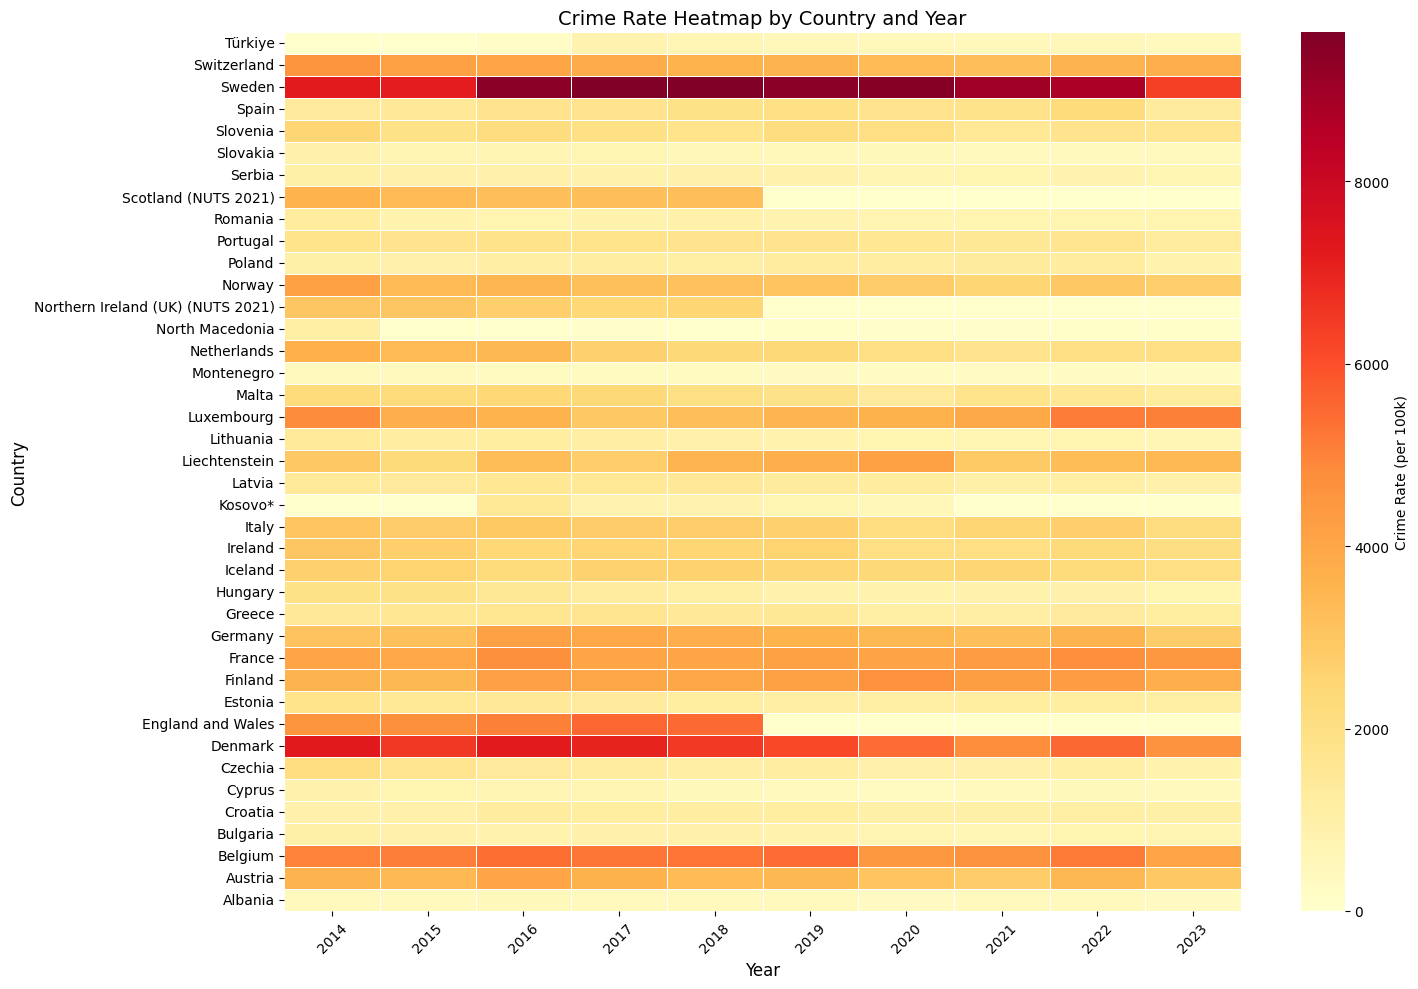

In [ ]:
heatmap_data = grouped.pivot_table(
    index="Country",
    columns="Year",
    values="Total_Crime",
    fill_value=0 
).sort_index(ascending=False)  

plt.figure(figsize=(15, 10))
sns.heatmap(
    heatmap_data,
    annot=False,  
    cmap="YlOrRd",  
    linewidths=0.5,
    cbar_kws={"label": "Crime Rate (per 100k)"}
)

plt.title("Crime Rate Heatmap by Country and Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()